# Plant Dataset *Arabidopsis thaliana*

For this experiment, we will be doing low throughput analysis on a plant dataset, Arabidopsis thaliana. Specifically, the focus is on the leaf rather than the root.

A. thaliana is quite popular for studying plant development due to its short generation time and ease of placement in the lab. 

The raw datasets can be downloaded here: https://www.ncbi.nlm.nih.gov/sra/SRX9490623 


### Import Libraries

To begin, let's run the following two cells to install the libraries and packages that we will need for our analysis.

In [ ]:
!pip install scanpy
!pip install harmonypy
!pip install scikit-misc
!pip3 install leidenalg

     |████████████████████████████████| 2.0 MB 2.2 MB/s 
     |████████████████████████████████| 80 kB 7.1 MB/s 
     |████████████████████████████████| 127 kB 22.7 MB/s 
     |████████████████████████████████| 1.1 MB 22.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=055734851593550eea4040f33c7bf9166c44d59d8da1b414c8942317858ceec8
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=806c68d451d29278fea7d91d8737ff7ffa39ac047e3db1275eeb94349eb74de1
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=8119853e97fba75516c5a41768afc00a0437c9dc0518a98c321eca7261337aca
  Stored in directory: /root/.cache/

In [ ]:
while True:
    try:
        import sys
        import os
        import numpy as np
        import pandas as pd
        import scanpy as sc
        import seaborn as sb
        import matplotlib.pyplot as plt
        break
    except:
        print("***Some packages have not been installed. Installing now...***")
        import subprocess
        import urllib.request

        # Retrieve installer if not available
        remove = False
        if not os.path.exists("get-pip.py"):
            urllib.request.urlretrieve("https://bootstrap.pypa.io/get-pip.py", "get-pip.py")
            remove = True
        subprocess.check_call([sys.executable, "get-pip.py"])
        # Download and install packages if not installed
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])

        # Packages used but not included in scanpy package
        subprocess.check_call([sys.executable, "-m", "pip", "install", "harmonypy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-misc"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "leidenalg"])

        # Remove installer if it wasn't available before for discretion
        if remove: os.remove("get-pip.py")
print("Package import success!")

Package import success!


### Parse Commands and Import data

These will be default numbers if the user does not change these inputs. Much of these are variable throughout experiments so the defaults will be basic at best.

In [ ]:
# file_location = "data/"
batch_effect = None
n=-1                    #Initialized later
cluster_res = 0.5
min_cells = 0
min_genes = 0
genes = []

cellranger_script =""
string_id=""
reference_transcriptome=""
fastqs=""
sample=""
expected_cells=0
local_cores=0
local_mem=0

In [ ]:
#Cellranger Arguments
cellranger_script_arg = "--script"
string_id_arg = "--id"
reference_transcriptome_arg = "--transcriptome"
fastqs_arg = "--fastqs"
sample_arg = "--sample"
expected_cells_arg = "--min_genes"
local_cores_arg = "--cores"
local_mem_arg = "--mem"

These arguments will be dependent on user input. User will check visualizations and other experiment variables to decide input to optimize the experiment to their needs.



In [ ]:
#Scanpy Arguments
file_arg = "--loc"
batch_arg = "--batch"
n_arg = "--neighbors"
resoution_arg = "--res"
cell_arg = "--min_cells"
gene_arg = "--min_genes"
display_arg = "--genes"

Parse arguments for some user inputs. Our python script will check these arguments but they are currently not necessary in our jupyter notebook.


In [ ]:
args = sys.argv[1:]
for arg in args:
    if file_arg+"=" in arg:
        file_location = arg[arg.index("=") + 1:]
    elif batch_arg+"=" in arg:
        batch_effect = arg[arg.index("=") + 1:]
    elif n_arg+"=" in arg:
        n = int(arg[arg.index("=") + 1:])
    elif resoution_arg+"=" in arg:
        cluster_res = float(arg[arg.index("=") + 1:])
    elif cell_arg+"=" in arg:
        min_cells = float(arg[arg.index("=") + 1:])
    elif gene_arg+"=" in arg:
        min_genes = float(arg[arg.index("=") + 1:])

    elif cellranger_script_arg+"=" in arg:
        cellranger_script = arg[arg.index("=") + 1:]
    elif string_id_arg+"=" in arg:
        string_id = arg[arg.index("=") + 1:]
    elif reference_transcriptome_arg+"=" in arg:
        reference_transcriptome = arg[arg.index("=") + 1:]
    elif fastqs_arg+"=" in arg:
        fastqs = arg[arg.index("=") + 1:]
    elif sample_arg+"=" in arg:
        sample = arg[arg.index("=") + 1:]
    elif expected_cells_arg+"=" in arg:
        expected_cells = float(arg[arg.index("=") + 1:])
    elif local_cores_arg+"=" in arg:
        local_cores = float(arg[arg.index("=") + 1:])
    elif local_mem_arg+"=" in arg:
        local_mem = float(arg[arg.index("=") + 1:])

    elif display_arg+"=" in arg:                 #Genes listed must be comma separated
        genes = arg[arg.index("=") + 1:].split(",")

    else: pass
        #sys.exit(arg+" is not a valid argument!")

 ***
Lets read in the data from the cellranger output. Cellranger outputs a features.tsv file, a barcode file, and the matrix file. Features are the genes, barcode are the cells, and the matrix is the actual data. Anndata is a Scanpy object that can hold all these important variables and data.

In [ ]:
adata = sc.read_10x_mtx("data/")
if n == -1:
  n = round(np.sqrt(adata.n_obs))

/usr/local/lib/python3.7/dist-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['AIP1-1', 'AIP1-2', 'CPN10-1', 'CPN10-2', 'PEX3-1']
  + str(example_colliding_values)


### View Data

In [ ]:
print("adata.obs length: "+str(adata.n_obs))
adata.obs.head()

adata.obs length: 3971


""
AAACCTGCAATTCCTT-1
AAACCTGCACAGGAGT-1
AAACCTGGTTGTGGCC-1
AAACCTGTCCTATGTT-1
AAACCTGTCGAGGTAG-1


In [ ]:
print("adata.var length: "+str(adata.n_vars))
adata.var.head()

adata.var length: 27655


,gene_ids,feature_types
NAC001,gene:AT1G01010,Gene Expression
ARV1,gene:AT1G01020,Gene Expression
NGA3,gene:AT1G01030,Gene Expression
DCL1,gene:AT1G01040,Gene Expression
PPA1,gene:AT1G01050,Gene Expression


Lets view the highest expressed genes.

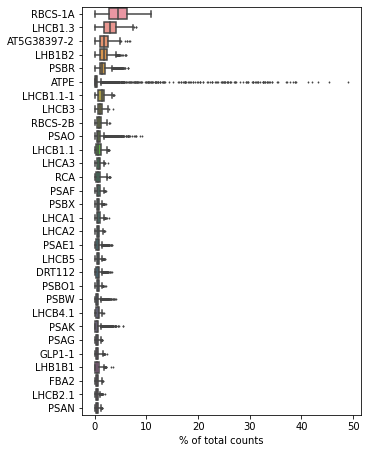

In [ ]:
sc.pl.highest_expr_genes(adata)

RBCS-1A (Ribulose biphosphate carboxylase small chain 1A) encodes a small unit necessary for RUBISCO, part of the Calvin/C3 cycle. As a brief review, the Calvin cycle fixes atmospheric CO2 to convert to glucose for photorespiration and photosynthesis. Rubisco in particular is the most abundant enzyme on Earth, serving as the first step for carbon entry. In this context, the high percentage of RBCS-XX is expected for leaf photosynthetic capacity. 

Similarly, LHCB1.3 is a part of the light harvesting complex to encode for chlorophyll a-b binding proteins. It, along with LHCB1-2-3, forms the major antenna complex of LHCII. The LHCII complex captures the majority of the photons that will be converted to biomass and energy. The various configurations of the trimers are complementary toward one another. LHCB1.3 specifically is able to bind multiple chlorophyll and carotenoids.

AT5G38397.1 is a hypothetical gene which has been recently documented (2018), encoding for the protein of the same name.

PSA_ participates in electron transfer and excitation between Photosystem I and II proteins. 

## Quality Control

### Basic Filtering

Our first important step in our analysis will be to do some quality control. Our 3 most important steps of quality control are:
- Basic filtering 
- Removal of highly expressed genes
- Batch Effect correction

In a standard scRNAseq experiment, there will be 4 steps, including removing MT reads. But of course, of spaceflight experiments, we at Genelab have decided to not include this step in our analysis.

***

Our analysis library of choice, scanpy, has a convient function that allows us calculate a number of quality metrics about the data. 

sc.pp.calculate_qc_metrics will give us 2 dataframes, a cell quality dataframe and a gene quality dataframe.

In [ ]:
# Quality control - calculate QC cmetrics
stats = sc.pp.calculate_qc_metrics(adata)
cell_qc_dataframe = stats[0]
gene_qc_dataframe = stats[1]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Lets take a quick look at the cell and gene qc dataframes.

In [ ]:
cell_qc_dataframe.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCTGCAATTCCTT-1,4618,8.437934,49668.0,10.813136,48.753725,57.316582,65.992188,78.708625
AAACCTGCACAGGAGT-1,5305,8.576594,57262.0,10.955410,48.856135,57.444728,65.409870,76.714051
AAACCTGGTTGTGGCC-1,7681,8.946635,51062.0,10.840816,26.299401,33.328111,41.449610,54.911676
AAACCTGTCCTATGTT-1,4295,8.365440,50575.0,10.831232,50.000989,58.700939,67.855660,80.747405
AAACCTGTCGAGGTAG-1,4014,8.297793,25591.0,10.150035,46.629674,54.726271,62.834590,74.936501


In [ ]:
gene_qc_dataframe.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
NAC001,61,0.022412,0.022165,98.463863,89.0,4.499810
ARV1,821,0.306472,0.267330,79.325107,1217.0,7.104965
NGA3,96,0.043062,0.042161,97.582473,171.0,5.147494
DCL1,197,0.054646,0.053205,95.039033,217.0,5.384495
PPA1,2124,1.726517,1.003025,46.512214,6856.0,8.833025


These metrics will be used to graph our quality control graphs to find thresholds.

***

In this case, there are no cells with a minimum number of genes from around 0-250, meaning there is no real filtering needed in this case.

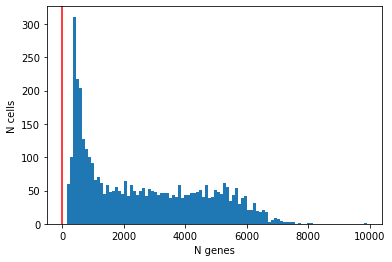

In [ ]:
fig, ax = plt.subplots()
plt.axvline(0, color='red')

plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.show()

Zooming in

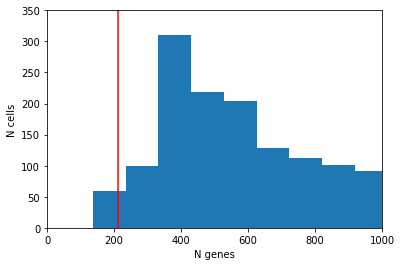

In [ ]:
fig, ax = plt.subplots()
plt.axvline(210, color='red')

plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axis([0, 1000, 0, 350])
plt.show()

In this case, 210 will be a good threshold.

Our next order of business is to filter out genes that who have low expression levels across cells. It is important to do gene filtering after cell filtering because some genes may be detected only in low quality cells. 

Lets start by graphing cells vs the number of genes they express. 

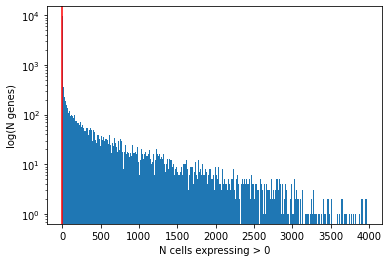

In [ ]:
fig, ax = plt.subplots()
plt.axvline(0, color='red')

plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') 
plt.yscale('log')
plt.show()

It seems as if most cells express a good number of genes, which we would expect as a cell. Lets take a closer look at at around zero.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


(0.0, 10.0, 0.6323124376968503, 100000.0)

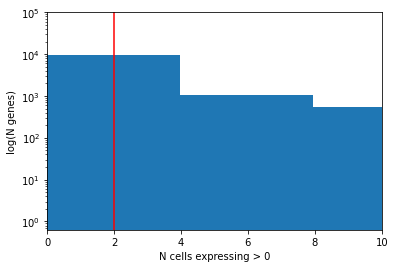

In [ ]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.axvline(2, color='red')
plt.ylabel('log(N genes)') 
plt.yscale('log')
plt.axis([0, 10, 0, 100000])

In this case, 1 will be a good line for the threshold. 




For our defaults, because basic filtering be extremely variable throughout experiments, we have decided to keep defaults at 1% until user input after seeing graphs. However, in this experiment, it is not really necessary to do any cell filtering so we will change cell to 0 and and make gene filter at a flat 2.

In [ ]:
unfiltered_genes = adata.var_names
cell_filter_percentile = 0.01
gene_filter_percentile = 0.01

cell_filter_percentile = 0
gene_filter_percentile = 2


#### Filter

In [ ]:
if min_cells != 0 or min_genes != 0:             #User input filtering
  sc.pp.filter_cells(adata, min_genes = min_cells)
  sc.pp.filter_genes(adata, min_cells = min_genes)
else:                                            #Percentile-based filtering (default)
  stats = sc.pp.calculate_qc_metrics(adata)
  gene_counts_mean = np.mean(stats[0]['n_genes_by_counts'])
  cell_counts_mean = np.mean(stats[1]['n_cells_by_counts'])

  sc.pp.filter_cells(adata, min_genes = 210)
  sc.pp.filter_genes(adata, min_cells = 1)

In [ ]:
filtered_genes = np.setdiff1d(unfiltered_genes, adata.var_names)
print(str(len(filtered_genes))+" genes filtered")

7321 genes filtered


#### To compare filter results

Batch effect correction is a quality control method of lowering technical noise. It can help us visualize more complete clusters.

In [ ]:
# Review obs after draft is complete
if not batch_effect == None:
  sc.pp.pca(adata)
  sc.external.pp.harmony_integrate(adata, key=batch_effect)

### Normalize and Logarithmize Data

As its name suggests, sc.pp.normalize_total will normalize the total number of counts per cell so that every cell will have the same number of total counts. Normalization will help to preserve biological heterogeneity without the influence of any technical noise like sequencing depth and gene abundance.

target_sum = 1e6 here refers to counts per million. 

Although different methods of normalization does exist, that are more accurate and have better performance, the CPM method is more flexible and scalable to all datasets and pipelines making it the best choice for our Genelab pipeline.

sc.pp.log1p helps to logarithmize the data to improve data "symmetry" on a linear scale for more relevant and accurate data. For further information on this topic, feel free to check out the following link: https://blog.qbaseplus.com/seven-tips-for-bio-statistical-analysis-of-gene-expression-data

In [ ]:

sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)

### Remove highly variable genes

Determine and remove highly variable genes based on each genes' mean and variance. Removing these genes eliminates noise due to high variability in the data.

Algorithm: Each gene is put into 20 'bins' based and their mean and variance. Each gene is then normalized based on the other genes in their bin. If a gene's normalized dispersion is greater or equal to a z-score of 2 (~98th percentile) AND the gene has a low mean cell count, it is marked highly variable.

Note: warning just means it will proceed to automatically calculate PCA since it was not done beforehand.

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat', min_disp=2)
highly_variable = adata[:, adata.var.highly_variable==True].var_names
print(str(len(adata.var[adata.var['highly_variable']==True]))+"/"+str(adata.n_vars)+" genes are highly variable")
adata = adata[:, adata.var.highly_variable==False]

466/20334 genes are highly variable


### K-Nearest Neighbors

Calculate the distance between each cell using the KNN algorithm. Distances will be used to cluster the cells in the next step.

Default (n=sqrt(adata.n_obs)): setting n as the square root of the length of the data is the general consensus if n is not provided.

Sources:

https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb

https://discuss.analyticsvidhya.com/t/how-to-choose-the-value-of-k-in-knn-algorithm/2606/7

https://stackoverflow.com/questions/11568897/value-of-k-in-k-nearest-neighbor-algorithm

In [ ]:
sc.pp.neighbors(adata, n_neighbors=n)

         Falling back to preprocessing with `sc.pp.pca` and default params.


### Cluster

Cluster/Group each cell based on the distances calculated in the previous step using the Leiden algorithm.

'resolution' determines the amount of clusters that will be formed (default: 1.0. The higher the resolution, the more clusters in the result)

In [ ]:
sc.tl.leiden(adata, resolution=1.4)

## Visualize Results

Prepares the data to be visualized by simplifying multiple dimensions down to two dimensional coordinates using the UMAP algorithm. 

This algoithm also uses the distances calculated using 'neighbors()' 

In [ ]:
sc.tl.umap(adata)

### Clusters

Plot the UMAP data and color based on the clusters determined previously. We will later use label these clusters with cell types using marker gene identification.


... storing 'feature_types' as categorical


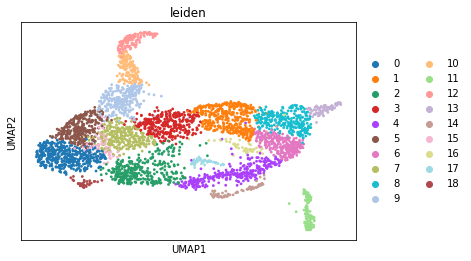

In [ ]:
sc.pl.umap(adata, color=['leiden'])

### Color based on selected gene(s)

Color cells based on their expression of a specific gene. If list of genes was not provided, the first 16 genes will be displayed.

Note: purple = no expression

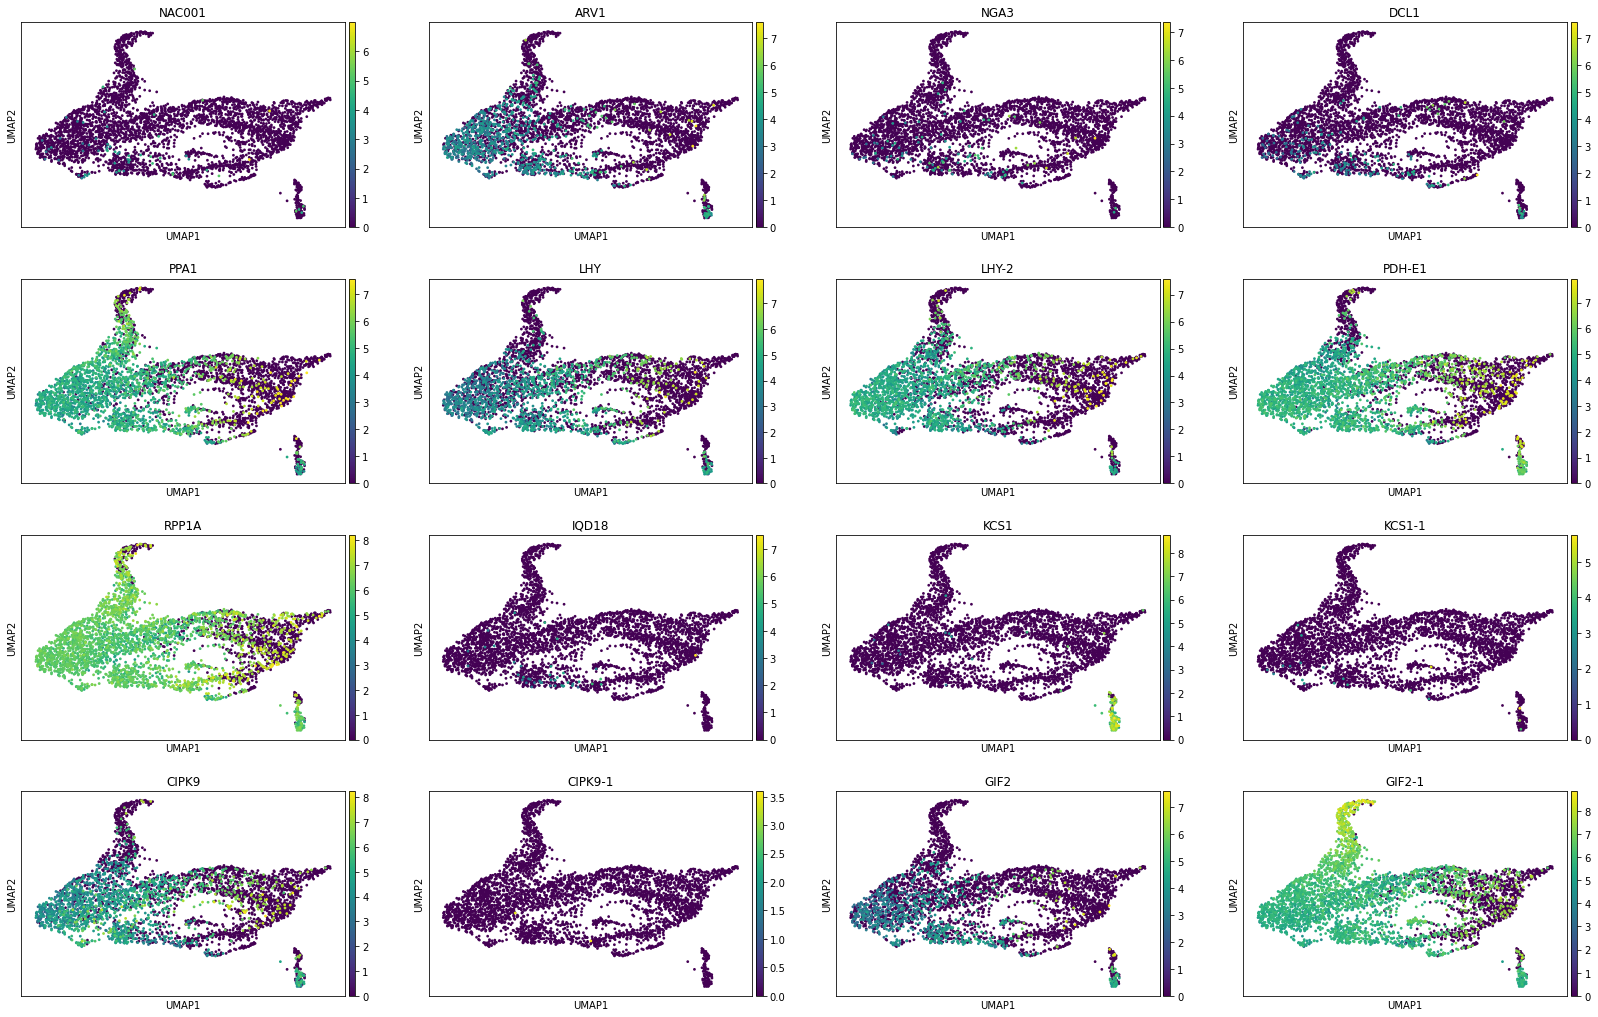

In [ ]:
view_genes = []
if len(genes) != 0:    #Display selected genes' expression
    for gene in genes:
        if gene in adata.var_names:
            view_genes.append(gene)
        elif gene in highly_variable:
            print(gene+" gene was highly variable and was filtered out.")
        elif gene in filtered_genes:
            print(gene+" gene had been filtered out.")
        else:
            print(gene+" gene does not exist in the dataset.")
else:                  #Display expression of the first 16 genes in adata
    #View the first 16 genes
    view_genes = []
    i = 16
    for gene in adata.var_names:
        view_genes.append(gene)
        i -= 1
        if i==0: break

sc.pl.umap(adata, color=view_genes)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


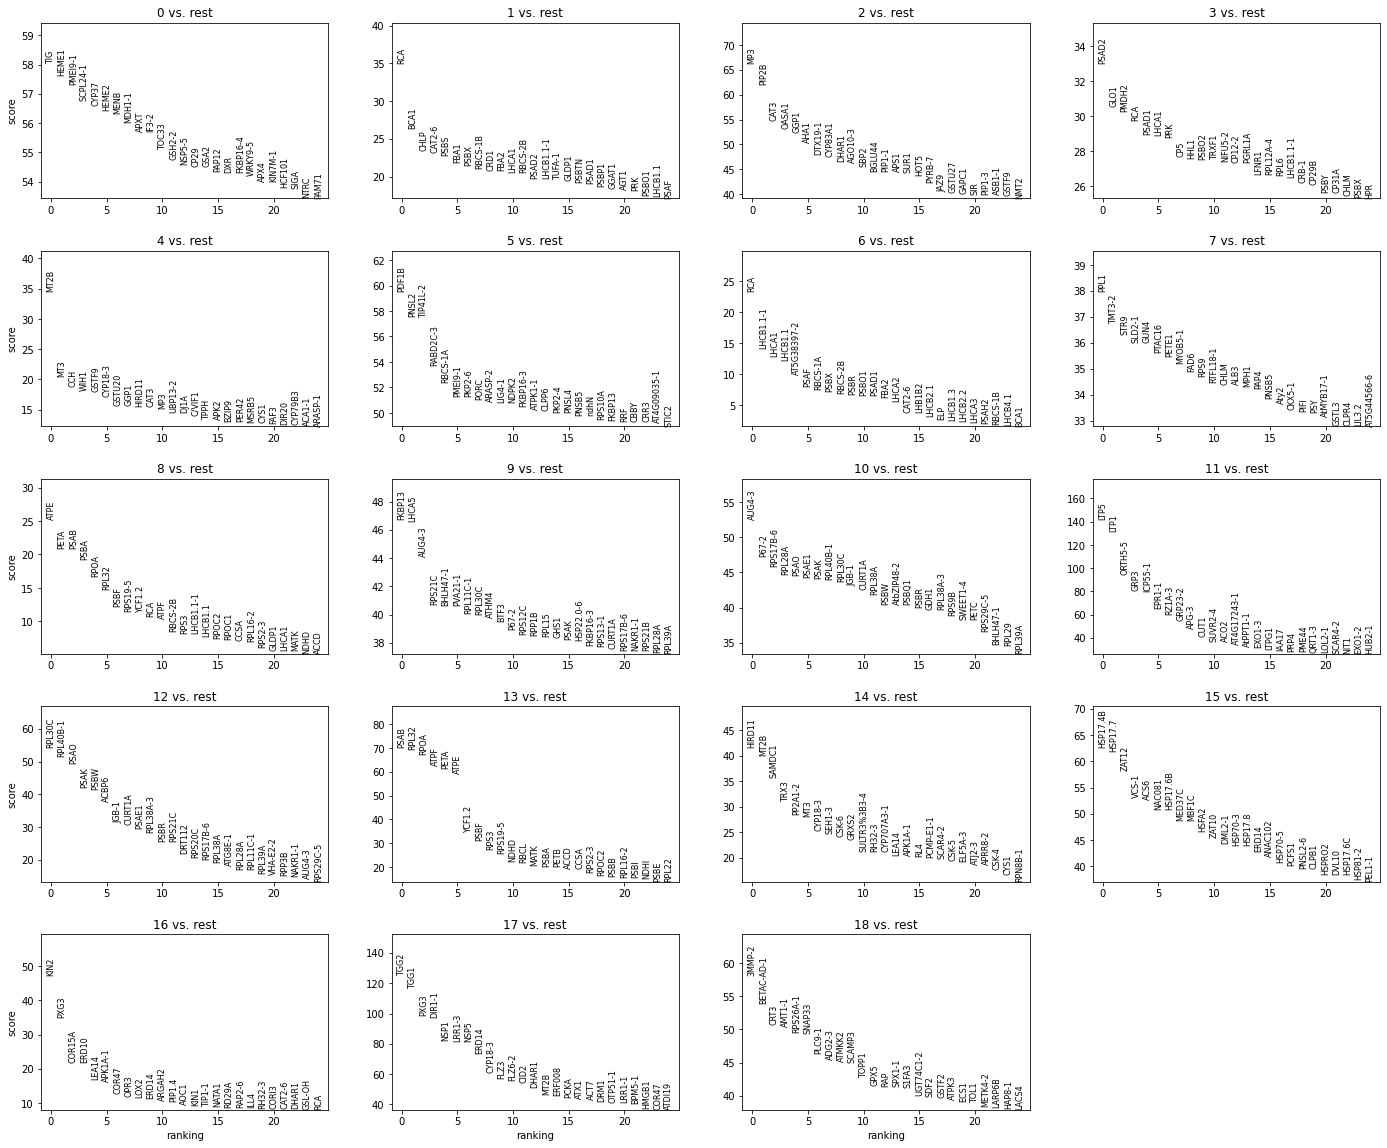

In [ ]:
results_file = 'write/arabidopsis.h5ad'
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,TIG,RCA,MP3,PSAD2,MT2B,PDF1B,RCA,PPL1,ATPE,FKBP13,AUG4-3,LTP5,RPL30C,PSAB,HIRD11,HSP17.4B,KIN2,TGG2,3MMP-2
1,HEME1,BCA1,PIP2B,GLO1,MT3,PNSL2,LHCB1.1-1,TMT3-2,PETA,LHCA5,P67-2,LTP1,RPL40B-1,RPL32,MT2B,HSP17.7,PXG3,TGG1,BETAC-AD-1
2,PMEI9-1,CHLP,CAT3,PMDH2,CCH,TIP41L-2,LHCA1,STR9,PSAB,AUG4-3,RPS17B-6,ORTH5-5,PSAO,RPOA,SAMDC1,ZAT12,COR15A,PXG3,CRT3
3,SCPL24-1,CAT2-6,OASA1,RCA,WIH1,RABD2C-3,LHCB1.1,SLD2-1,PSBA,RPS21C,RPL28A,GRP3,PSAK,ATPF,TRX3,VCS-1,ERD10,DIR1-1,AMT1-1
4,CYP37,PSBS,GGP1,PSAD1,GSTF9,RBCS-1A,AT5G38397-2,GUN4,RPOA,BHLH47-1,PSAO,ICP55-1,PSBW,PETA,PP2A1-2,ACS6,LEA14,NSP1,RPS26A-1
5,HEME2,FBA1,AHA1,LHCA1,CYP18-3,PMEI9-1,PSAF,PTAC16,RPL32,PVA21-1,PSAE1,EPR1-1,ACBP6,ATPE,MT3,NAC081,APK1A-1,LRR1-3,SNAP33
6,MENB,PSBX,DTX19-1,PRK,GSTU20,PKP2-6,RBCS-1A,PETE1,PSBF,RPL11C-1,PSAK,RZ1A-3,JGB-1,YCF1.2,CYP18-3,HSP17.6B,COR47,NSP5,PLC9-1
7,MDH1-1,RBCS-1B,CYP83A1,CP5,GGP1,PORC,PSBX,MYOB5-1,RPS19-5,RPL30C,RPL40B-1,GRP23-2,CURT1A,PSBF,SEH1-3,MED37C,OPR3,ERD14,ADG2-3
8,APXT,CRD1,DHAR1,HHL1,HIRD11,ARASP-2,RBCS-2B,FAD6,YCF1.2,ATHM4,RPL30C,APG-3,PSAE1,RPS3,CSK-6,MBF1C,LOX2,CYP18-3,ATMKK2
9,IF3-2,FBA2,AGO10-3,PSBO2,CAT3,LIG4-1,PSBR,RPS9,RCA,BTF3,JGB-1,CUT1,RPL38A-3,RPS19-5,GRXS2,HSFA2,ERD14,FLZ3,SCAMP3


#Annotation

In [ ]:
!git clone https://github.com/LucasESBS/scoreCT

Cloning into 'scoreCT'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 197 (delta 3), reused 12 (delta 3), pack-reused 185
Receiving objects: 100% (197/197), 114.10 MiB | 36.08 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
!mv scoreCT/src/scorect_api.py /content/

In [ ]:
import scorect_api as ct

In [ ]:
ref_marker = ct.read_markers_from_file("A_thaliana_leaf_genes_corrected.csv")

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', n_genes=len(adata.var))

In [ ]:
marker_df = ct.wrangle_ranks_from_anndata(adata)
print(marker_df.head())

Wrangling: Number of markers used in ranked_gene_groups:  19868
Wrangling: Groups used for ranking: leiden
     z_score  adj_pvals      gene cluster_number
0  58.049850        0.0       TIG              0
1  57.642834        0.0     HEME1              0
2  57.332573        0.0   PMEI9-1              0
3  56.767078        0.0  SCPL24-1              0
4  56.612766        0.0     CYP37              0


In [ ]:
# Let's set parameters first: K = number of genes included in the ranking
# m = number of bins used to divide the top K genes.
K = 300
m = 15
# all genes in DGE test
background = adata.var.index.tolist()
# function run
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background)

In [ ]:
cluster_assign = adata.obs['leiden']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.1)
# Add to anndata object
#adata.obs['scorect'] = celltype_assign
#sc.pl.umap(adata, color=['cell_type','scorect'], title=['True','Predicted'], cmap='Set2')

In [ ]:
adata.obs['cell_type'] = celltype_assign

In [ ]:
adata.obs.head()

,n_genes,leiden,cell_type
AAACCTGCAATTCCTT-1,4618,5,NA
AAACCTGCACAGGAGT-1,5305,0,NA
AAACCTGGTTGTGGCC-1,7681,18,NA
AAACCTGTCCTATGTT-1,4295,5,NA
AAACCTGTCGAGGTAG-1,4014,7,NA


In [ ]:
adata.obs.to_excel('a_thaliana_annotation.xlsx')

... storing 'cell_type' as categorical


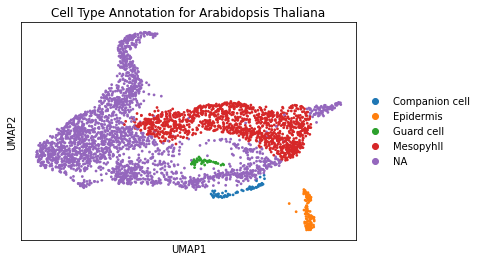

In [ ]:
sc.pl.umap(adata, color=['cell_type'], title=['Cell Type Annotation for Arabidopsis Thaliana'])